In [1]:
# machine learning module
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import pandas as pd
import numpy as np

# ANN module
import torch
from torch import nn, optim                           # torch 에서 제공하는 신경망 기술, 손실함수, 최적화를 할 수 있는 함수들을 불러온다.
from torch.utils.data import DataLoader, Dataset      # 데이터를 모델에 사용할 수 있게 정리해주는 라이브러리.
import torch.nn.functional as F                       # torch 내의 세부적인 기능을 불러옴.

# Loss
from sklearn.metrics import mean_squared_error        # regression 문제의 모델 성능 측정을 위해서 MSE를 불러온다.

import matplotlib.pyplot as plt

In [2]:
bos = load_boston()

df = pd.DataFrame(bos.data)       # bos.data: 데이터 불러오기
df.columns = bos.feature_names    # bos.feature_names: 컬럼명 불러오기
df['Price'] = bos.target          # bos.target: 타겟값 불러오기

C:\Users\JWBaek-Eng\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the California housing data

In [3]:
# 데이터를 넘파이 배열로 만들기
X = df.drop('Price', axis=1).to_numpy() # 데이터프레임에서 타겟값(Price)을 제외하고 넘파이 배열로 만들기
Y = df['Price'].to_numpy().reshape((-1,1)) # 데이터프레임 형태의 타겟값을 넘파이 배열로 만들기

# 데이터 스케일링
# sklearn에서 제공하는 MinMaxScaler 
# (X-min(X))/(max(X)-min(X))을 계산
scaler = MinMaxScaler() 
scaler.fit(X) 
X = scaler.transform(X)

scaler.fit(Y)
Y = scaler.transform(Y)

In [4]:
print(X.shape)
print(Y.shape)

(506, 13)
(506, 1)


In [5]:
# torch의 Dataset 을 상속.
class TensorData(Dataset):

    def __init__(self, x_data, y_data):
        self.x_data = torch.FloatTensor(x_data)
        self.y_data = torch.FloatTensor(y_data)
        self.len = self.y_data.shape[0]

    def __getitem__(self, index):

        return self.x_data[index], self.y_data[index] 

    def __len__(self):
        return self.len

In [6]:
# 전체 데이터를 학습 데이터와 평가 데이터로 나눈다.
# 기준으로 잡은 논문이 전체 데이터를 50%, 50%로 나눴기 때문에 test size를 0.5로 설정한다.
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.5)

# 학습 데이터, 시험 데이터 배치 형태로 구축하기
trainsets = TensorData(X_train, Y_train)
trainloader = torch.utils.data.DataLoader(trainsets, batch_size=32, shuffle=True)

testsets = TensorData(X_test, Y_test)
testloader = torch.utils.data.DataLoader(testsets, batch_size=32, shuffle=False)

In [7]:
class Regressor(nn.Module):
    def __init__(self):
        super().__init__() # 모델 연산 정의
        self.fc1 = nn.Linear(13, 50, bias=True) # 입력층(13) -> 은닉층1(50)으로 가는 연산
        self.fc2 = nn.Linear(50, 30, bias=True) # 은닉층1(50) -> 은닉층2(30)으로 가는 연산
        self.fc3 = nn.Linear(30, 1, bias=True) # 은닉층2(30) -> 출력층(1)으로 가는 연산
        self.dropout = nn.Dropout(0.2) # 연산이 될 때마다 20%의 비율로 랜덤하게 노드를 없앤다.

    def forward(self, x): # 모델 연산의 순서를 정의
        x = F.relu(self.fc1(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
        x = self.dropout(F.relu(self.fc2(x))) # 은닉층2에서 드랍아웃을 적용한다.(즉, 30개의 20%인 6개의 노드가 계산에서 제외된다.)
        x = F.relu(self.fc3(x)) # Linear 계산 후 활성화 함수 ReLU를 적용한다.  
      
        return x
    
# 주의 사항
# 드랍아웃은 과적합(overfitting)을 방지하기 위해 노드의 일부를 배제하고 계산하는 방식이기 때문에 절대로 출력층에 사용해서는 안 된다.

In [8]:
model = Regressor()
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-7)

In [9]:
loss_ = [] # loss를 저장할 리스트.
n = len(trainloader)

for epoch in range(400):

  running_loss = 0.0 # 한 에폭이 돌 때 그안에서 배치마다 loss가 나온다. 즉 한번 학습할 때 그렇게 쪼개지면서 loss가 다 나오니 MSE를 구하기 위해서 사용한다.

  for i, data in enumerate(trainloader, 0): # 무작위로 섞인 32개의 데이터가 담긴 배치가 하나씩 들어온다.
    
    inputs, values = data # data에는 X, Y가 들어있다.

    optimizer.zero_grad() # 최적화 초기화.

    outputs = model(inputs) # 모델에 입력값을 넣어 예측값을 산출한다.
    loss = criterion(outputs, values) # 손실함수를 계산. error 계산.
    loss.backward() # 손실 함수를 기준으로 역전파를 설정한다.
    optimizer.step() # 역전파를 진행하고 가중치를 업데이트한다.

    running_loss += loss.item() # epoch 마다 평균 loss를 계산하기 위해 배치 loss를 더한다.
  
  loss_.append(running_loss/n) # MSE(Mean Squared Error) 계산


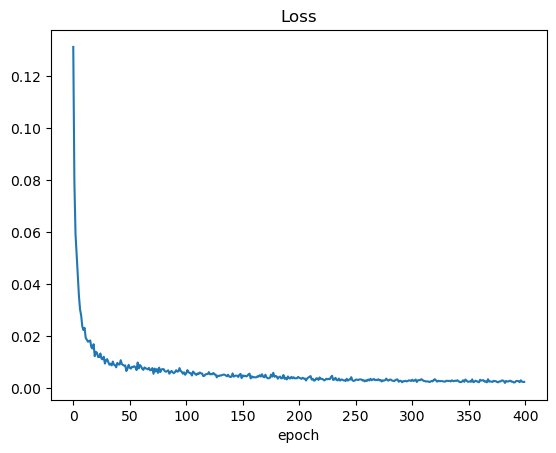

In [10]:
plt.plot(loss_)
plt.title('Loss')
plt.xlabel('epoch')
plt.show()

In [11]:
def evaluation(dataloader):

  predictions = torch.tensor([], dtype=torch.float) # 예측값을 저장하는 텐서.
  actual = torch.tensor([], dtype=torch.float) # 실제값을 저장하는 텐서.

  with torch.no_grad():
    model.eval() # 평가를 할 땐 반드시 eval()을 사용해야 한다.

    for data in dataloader:
      inputs, values = data
      outputs = model(inputs)

      predictions = torch.cat((predictions, outputs), 0) # cat함수를 통해 예측값을 누적.
      actual = torch.cat((actual, values), 0) # cat함수를 통해 실제값을 누적.

  predictions = predictions.numpy() # 넘파이 배열로 변경.
  actual = actual.numpy() # 넘파이 배열로 변경.
  rmse = np.sqrt(mean_squared_error(predictions, actual)) # sklearn을 이용해 RMSE를 계산.

  return rmse

In [12]:
train_rmse = evaluation(trainloader) # 원래는 이렇게 하면 안되지만, 비교를 위해서 train을 넣어서 본다. 
test_rmse = evaluation(testloader)

print(f'train rmse:{train_rmse}')
print(f'test rmse:{test_rmse}')

train rmse:0.035112787038087845
test rmse:0.09775451570749283


In [13]:
train_rmse = evaluation(trainloader) # 원래는 이렇게 하면 안되지만, 비교를 위해서 train을 넣어서 본다. 
test_rmse = evaluation(testloader)

print(f'train rmse:{train_rmse}')
print(f'test rmse:{test_rmse}')

train rmse:0.035112787038087845
test rmse:0.09775451570749283
